# Astrophotography Pipeline: Andromeda

This notebook walks through a full deep-sky processing pipeline:

1. Configuration
2. Calibration (CR2 to FITS, master calibration frames, calibrated lights)
3. Alignment (register all light frames)
4. Stacking (sigma-clipped mean)
5. Post-processing (gradient removal, star control, color stretch)

**Dataset:** Andromeda (M31) from Nebula Photos

## Setup and Requirements

In [24]:
import sys, os
import numpy as np
import rawpy
from astropy.io import fits
from astropy import units as u
from ccdproc import CCDData, ImageFileCollection
import ccdproc as ccdp
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
from astroalign import register
from astropy.stats import sigma_clip
from scipy.ndimage import median_filter, gaussian_filter
from skimage.restoration import denoise_bilateral
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt
import tkinter as tk
from PIL import Image, ImageTk
import gc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

req_path = Path("requirements.txt")
print("Using requirements file at:", req_path.resolve())

if not req_path.exists():
    raise FileNotFoundError("requirements.txt not found next to this notebook.")

# Jupyter magic: installs into the current kernel
%pip install -r requirements.txt

Using requirements file at: /Users/unknwn.dev/Code/School/CS/370/Astrophotography/requirements.txt
Note: you may need to restart the kernel to use updated packages.


## Path Configuration

In [2]:
# The script assumes your CR2s are in 'data/raw_data'
base_dir = Path("./data")
raw_dir = (
    base_dir / "raw_data"
)  # Create dir for raw photos with folder of the frame types
fits_dir = base_dir / "fits_data/"  # Create dir for fits data to be saved

# Define FITS Directories (Script will create these)
fits_bias_dir = fits_dir / "bias/"
fits_dark_dir = fits_dir / "dark/"
fits_flat_dir = fits_dir / "flat/"
fits_light_dir = fits_dir / "light/"
master_dir = fits_dir / "master_frames"
calibrated_dir = fits_dir / "calibrated_lights"

# Define FITS Header Keyword for Exposure Time
EXPOSURE_KEY = "EXPTIME"

# Naming convention for the final master frames
MASTER_BIAS_FILE = master_dir / "MasterBias.fit"
MASTER_DARK_FILE = master_dir / "MasterDark.fit"
MASTER_FLAT_FILE = master_dir / "MasterFlat.fit"


aligned_dir = fits_dir / "aligned_lights"
aligned_dir.mkdir(exist_ok=True)

stack_output = fits_dir / "stacked"
stack_output.mkdir(exist_ok=True)

## Preview Window Functions

In [3]:
def show_step_preview(prev_image_path, curr_image_path, window_title="Step Preview"):
    """
    Open a Tkinter window showing two images side-by-side:
    - Left:  previous step
    - Right: current step
    """

    # Create main window
    root = tk.Tk()
    root.title(window_title)

    # Main frame
    main_frame = tk.Frame(root)
    main_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

    # Left and right frames
    left_frame = tk.Frame(main_frame)
    right_frame = tk.Frame(main_frame)

    left_frame.pack(side=tk.LEFT, padx=10, pady=10)
    right_frame.pack(side=tk.LEFT, padx=10, pady=10)

    # Load images with PIL
    prev_img = Image.open(prev_image_path)
    curr_img = Image.open(curr_image_path)

    # Optional: simple resize to avoid enormous windows (adjust as needed)
    max_width = 600
    max_height = 600

# ==============================================================================

    def _resize_if_needed(img):
        w, h = img.size
        scale = min(max_width / w, max_height / h, 1.0)
        if scale < 1.0:
            new_size = (int(w * scale), int(h * scale))
            return img.resize(new_size, Image.LANCZOS)
        return img

    prev_img = _resize_if_needed(prev_img)
    curr_img = _resize_if_needed(curr_img)

    prev_tk = ImageTk.PhotoImage(prev_img)
    curr_tk = ImageTk.PhotoImage(curr_img)

    # Labels
    left_label_title = tk.Label(left_frame, text="Previous Step")
    left_label_title.pack()
    left_label = tk.Label(left_frame, image=prev_tk)
    left_label.image = prev_tk  # keep reference
    left_label.pack()

    right_label_title = tk.Label(right_frame, text="Current Step")
    right_label_title.pack()
    right_label = tk.Label(right_frame, image=curr_tk)
    right_label.image = curr_tk  # keep reference
    right_label.pack()

    # Start event loop
    root.mainloop()

    # Clean up
    gc.collect()

# ==============================================================================

# Make sure fits_dir exists even if this cell is run standalone
base_dir = Path("./data")
fits_dir = base_dir / "fits_data"

preview_dir = fits_dir / "previews"
preview_dir.mkdir(parents=True, exist_ok=True)

def stretch_for_preview(data, low_pct=0.5, high_pct=99.5):
    """
    Percentile-based stretch for display only.
    Similar to an auto STF in astro software.

    low_pct  : lower percentile to clip (e.g., 0.5)
    high_pct : upper percentile to clip (e.g., 99.5)
    """
    data = np.asarray(data, dtype=np.float32)

    # Handle NaNs/Infs
    finite = data[np.isfinite(data)]
    if finite.size == 0:
        return np.zeros_like(data, dtype=np.float32)

    low = np.percentile(finite, low_pct)
    high = np.percentile(finite, high_pct)

    if high <= low:
        high = low + 1e-6

    stretched = (data - low) / (high - low)
    stretched = np.clip(stretched, 0.0, 1.0)
    return stretched

# ==============================================================================

def make_preview_png(fits_path, png_path):
    """
    Load a FITS file, apply stretch_for_preview, save a grayscale PNG.
    This does NOT affect the science pipeline, only the previews.
    """
    fits_path = Path(fits_path)
    png_path = Path(png_path)

    if not fits_path.exists():
        print("FITS file not found:", fits_path)
        return

    data = fits.getdata(fits_path)

    # Apply display stretch
    data_disp = stretch_for_preview(data)

    plt.imsave(png_path, data_disp, cmap="gray")
    print("Saved preview PNG:", png_path)

# ==============================================================================

def _center_crop(data, frac=0.6):
    """
    Crop the array to the central region.
    frac is the fraction of the smaller dimension to keep (0<frac<=1).
    """
    h, w = data.shape
    size = int(min(h, w) * frac)
    y0 = (h - size) // 2
    x0 = (w - size) // 2
    return data[y0:y0+size, x0:x0+size]

# ==============================================================================

def stretch_pair_for_preview(data1, data2, low_pct=0.5, high_pct=99.5, crop=True):
    """
    Take two 2D arrays (same shape), optionally center-crop them,
    and apply the SAME percentile stretch to both.
    Returns (disp1, disp2) scaled to [0,1].
    """
    d1 = np.asarray(data1, dtype=np.float32)
    d2 = np.asarray(data2, dtype=np.float32)

    if crop:
        d1 = _center_crop(d1)
        d2 = _center_crop(d2)

    # Combine finite values from both for joint percentiles
    finite = np.concatenate([
        d1[np.isfinite(d1)].ravel(),
        d2[np.isfinite(d2)].ravel()
    ])

    if finite.size == 0:
        z = np.zeros_like(d1, dtype=np.float32)
        return z, z

    low = np.percentile(finite, low_pct)
    high = np.percentile(finite, high_pct)
    if high <= low:
        high = low + 1e-6

# ==============================================================================

    def _stretch(d):
        x = (d - low) / (high - low)
        return np.clip(x, 0.0, 1.0)

    return _stretch(d1), _stretch(d2)



---

# Image Calibration

This script performs basic astronomical image data reduction, converting raw camera files (`.CR2`) to standard **FITS** files and then using calibration frames to clean the images.

## 1. CR2 to FITS Conversion

The `convert_cr2_to_fits` function is the first step, ensuring all raw data is in an astronomical format.

| File Type | Source Directory (`raw_dir`) | Destination Directory (`fits_dest_dir`) | `IMAGETYP` |
| :--- | :--- | :--- | :--- |
| **Bias** | `raw/bias/` | `fits/bias/` | BIAS |
| **Dark** | `raw/dark/` | `fits/dark/` | DARK |
| **Flat** | `raw/flat/` | `fits/flat/` | FLAT |
| **Light** | `raw/light/` | `fits/light/` | LIGHT |

**Process:**
1.  **Read Raw:** Uses `rawpy.imread` to open the `.CR2` file.
2.  **Extract Data:** Extracts the raw, 16-bit, Bayered sensor data (`raw.raw_image_visible.astype(np.uint16)`).
3.  **Create FITS:** Writes the data to a FITS file, including metadata like `IMAGETYP` and `EXPOSURE` in the header.

In [4]:
def convert_cr2_to_fits(raw_src_dir, fits_dest_dir, image_type):
    """
    Converts all CR2 files in a source directory to FITS files
    in a destination directory using rawpy.
    """
    print(f"\n--- Converting {image_type} CR2s to FITS ---")
    raw_src_dir = Path(raw_src_dir)
    fits_dest_dir = Path(fits_dest_dir)

    # Create the destination directory if it doesn't exist
    fits_dest_dir.mkdir(parents=True, exist_ok=True)

    cr2_files = list(raw_src_dir.glob("*.CR2")) + list(raw_src_dir.glob("*.cr2"))
    if not cr2_files:
        print(f"Warning: No CR2 files found in {raw_src_dir}")
        return

    for cr2_path in tqdm(cr2_files, desc=f"Converting {image_type}"):
        try:
            with rawpy.imread(str(cr2_path)) as raw:
                # Extract the raw, 16-bit sensor data (Bayered)
                # This is what we want for calibration

                raw_image = raw.raw_image_visible.astype(np.uint16)

                # Extract essential metadata
                iso = 200
                exposure = 25
                # timestamp_obj = datetime.fromtimestamp(raw.timestamp)
                # timestamp_iso = timestamp_obj.isoformat()

                # Create a FITS Header
                header = fits.Header()
                header["IMAGETYP"] = (image_type, "Image type")
                header[EXPOSURE_KEY] = (exposure, "Exposure time in seconds")
                header["ISO"] = (iso, "Camera ISO setting")
                # header['DATE-OBS'] = (timestamp_iso, 'Observation start time')

                # Create a FITS HDU (Header Data Unit)
                hdu = fits.PrimaryHDU(data=raw_image, header=header)

                # Write the FITS file
                fits_filename = cr2_path.stem + ".fit"
                hdu.writeto(fits_dest_dir / fits_filename, overwrite=True)

        except Exception as e:
            print(f"\nError converting {cr2_path.name}: {e}")

    print(f"\nCompleted conversion for {image_type}.")
    

In [5]:
# Check if the raw directories exist
if not raw_dir.exists():
    print(f"Error: Raw data directory not found at {raw_dir}")
    print("Please create the directory structure as described.")
    sys.exit()

# Create all FITS directories first
for d in [
    fits_bias_dir,
    fits_dark_dir,
    fits_flat_dir,
    fits_light_dir,
    master_dir,
    calibrated_dir,
]:
    d.mkdir(parents=True, exist_ok=True)

# # Convert all CR2 files to FITS (Comment out lines below when you add files to your dir)
convert_cr2_to_fits(raw_dir / 'bias/', fits_bias_dir, 'BIAS')
convert_cr2_to_fits(raw_dir / 'dark/', fits_dark_dir, 'DARK')
convert_cr2_to_fits(raw_dir / 'flat/', fits_flat_dir, 'FLAT')
convert_cr2_to_fits(raw_dir / 'light/', fits_light_dir, 'LIGHT')

print("\n*** CR2 to FITS conversion complete! ***")


--- Converting BIAS CR2s to FITS ---


Converting BIAS: 100%|██████████| 37/37 [00:08<00:00,  4.37it/s]



Completed conversion for BIAS.

--- Converting DARK CR2s to FITS ---


Converting DARK: 100%|██████████| 17/17 [00:03<00:00,  4.41it/s]



Completed conversion for DARK.

--- Converting FLAT CR2s to FITS ---


Converting FLAT: 100%|██████████| 30/30 [00:07<00:00,  3.88it/s]



Completed conversion for FLAT.

--- Converting LIGHT CR2s to FITS ---


Converting LIGHT: 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]


Completed conversion for LIGHT.

*** CR2 to FITS conversion complete! ***


---

## 2. Master Frame Creation

Master Calibration Frames are created by combining multiple individual frames using **median stacking** with **sigma clipping** (to reject cosmic rays and noise outliers).

### A. Master Bias
* **Function:** `create_master_bias()`
* **Purpose:** Captures the camera's **electronic offset** and **read noise**.
* **Process:** Median-combine all individual **Bias** frames.

### B. Master Dark
* **Function:** `create_master_dark(\text{MB})$
* **Purpose:** Captures **thermal current** (hot pixels and glow).
* **Process:** **Subtract** $\text{MB}$ from all individual Dark frames, then median-combine the result.

### C. Master Flat
* **Function:** `create_master_flat(\text{MB}, \text{MD})$
* **Purpose:** Corrects **vignetting** and **dust/imperfections**.
* **Process:**
    1.  Subtract $\text{MB}$ from all individual Flat frames.
    2.  **Subtract Scaled** $\text{MD}$ (scaled to the Flat's exposure time).
    3.  Median-combine the result.
    4.  **Normalize** (divide by the median value) to set the average to 1.0.

### D. Light Calibration

The final, critical step where the Master Frames are applied to the frames.

* **Function:** `process_light_frames(\text{MB}, \text{MD}, \text{MF})$
* **Process (Applied to each Light Frame):**

    1.  **Subtract Bias:** $\text{Light}_{\text{Bias-Subtracted}} = \text{Raw Light} - \text{MB}$
    2.  **Subtract Dark:** $\text{Light}_{\text{Dark-Corrected}} = \text{Light}_{\text{Bias-Subtracted}} - (\text{MD} \times \text{Scale Factor})$
    3.  **Flat Correction:** $\text{Calibrated Light} = \frac{\text{Light}_{\text{Dark-Corrected}}}{\text{MF}}$

* **Output:** Calibrated FITS files are saved in the `calibrated_dir`.

In [6]:
def create_master_bias():
    if MASTER_BIAS_FILE.exists():
        print(f"\nLoading existing Master Bias from: {MASTER_BIAS_FILE.name}")
        return ccdp.CCDData.read(MASTER_BIAS_FILE, unit=u.adu)

    print(
        f"\n--- 1. Creating Master Bias Frame from {len(list(fits_bias_dir.glob('*.fit')))} files ---"
    )
    ifc = ImageFileCollection(fits_bias_dir)

    # Get a list of the FULL PATHS to the bias files
    files_to_combine = ifc.files_filtered(include_path=True)

    if not files_to_combine:
        print(f"Error: No FITS files found in {fits_bias_dir}")
        sys.exit()

    # Combine all 50 bias frames
    master_bias = ccdp.combine(
        files_to_combine,
        method="median",
        unit=u.adu,
        mem_limit=2.5e9,
        sigma_clip=True,
        sigma_clip_low_thresh=5,
        sigma_clip_high_thresh=5,
    )

    master_bias.write(MASTER_BIAS_FILE, overwrite=True)
    print(f"Master Bias saved to: {MASTER_BIAS_FILE.name}")
    return master_bias


def create_master_dark(master_bias):
    if MASTER_DARK_FILE.exists():
        print(f"\nLoading existing Master Dark from: {MASTER_DARK_FILE.name}")
        return ccdp.CCDData.read(MASTER_DARK_FILE, unit=u.adu)

    print(
        f"\n--- 2. Creating Master Dark Frame from {len(list(fits_dark_dir.glob('*.fit')))} files ---"
    )

    if not any(fits_dark_dir.glob("*.fit")):
        print(f"Error: No FITS files found in {fits_dark_dir}.")
        sys.exit()

    ifc = ImageFileCollection(fits_dark_dir, keywords=[EXPOSURE_KEY])

    # First, check the exposure times from the summary
    exp_times = set(ifc.summary[EXPOSURE_KEY])

    if len(exp_times) == 0:
        print(f"\n\nCRITICAL ERROR in 'create_master_dark':")
        print(
            f"Error: No '{EXPOSURE_KEY}' keyword found in any FITS files in {fits_dark_dir}."
        )
        print("This means the 'rawpy' conversion failed to get exposure times.")
        sys.exit()

    if len(exp_times) > 1:
        print(f"\n\nCRITICAL ERROR in 'create_master_dark':")
        print(
            f"Error: Your dark frames have multiple different exposure times: {exp_times}"
        )
        print(
            "A Master Dark can only be created from darks with the *exact same* exposure time."
        )
        sys.exit()

    dark_exposure_time = list(exp_times)[0] * u.s
    print(f"Found dark frames with a single exposure time: {dark_exposure_time}")

    dark_frames_to_combine = []

    # Get full paths and loop explicitly
    files_to_load = ifc.files_filtered(include_path=True)
    for f_path in files_to_load:
        dark_frame = CCDData.read(f_path, unit=u.adu)
        dark_subtracted = ccdp.subtract_bias(dark_frame, master_bias)
        dark_frames_to_combine.append(dark_subtracted)

    master_dark = ccdp.combine(
        dark_frames_to_combine,
        method="median",
        unit=u.adu,
        mem_limit=2.5e9,
        sigma_clip=True,
        sigma_clip_low_thresh=5,
        sigma_clip_high_thresh=5,
    )

    master_dark.header[EXPOSURE_KEY] = (
        dark_exposure_time.value,
        "Exposure time of master dark",
    )
    master_dark.write(MASTER_DARK_FILE, overwrite=True)
    print(f"Master Dark saved to: {MASTER_DARK_FILE.name}")
    return master_dark


def create_master_flat(master_bias, master_dark):
    if MASTER_FLAT_FILE.exists():
        print(f"\nLoading existing Master Dark from: {MASTER_FLAT_FILE.name}")
        return ccdp.CCDData.read(MASTER_FLAT_FILE, unit=u.adu)

    print(
        f"\n--- 3. Creating Master Flat Frame from {len(list(fits_flat_dir.glob('*.fit')))} files ---"
    )
    ifc = ImageFileCollection(fits_flat_dir)

    flat_frames_to_combine = []
    master_dark_exp = master_dark.header[EXPOSURE_KEY] * u.s

    files_to_load = ifc.files_filtered(include_path=True)
    for f_path in files_to_load:
        flat_frame = CCDData.read(f_path, unit=u.adu)
        flat_exposure_time = flat_frame.header[EXPOSURE_KEY] * u.s
        flat_subtracted = ccdp.subtract_bias(flat_frame, master_bias)
        flat_corrected = ccdp.subtract_dark(
            flat_subtracted,
            master_dark,
            dark_exposure=master_dark_exp,
            data_exposure=flat_exposure_time,
            scale=True,
        )
        flat_frames_to_combine.append(flat_corrected)

    master_flat = ccdp.combine(
        flat_frames_to_combine,
        method="median",
        unit=u.adu,
        mem_limit=2.5e9,
        sigma_clip=True,
        sigma_clip_low_thresh=5,
        sigma_clip_high_thresh=5,
    )

    master_flat.data /= np.median(master_flat.data)
    master_flat.write(MASTER_FLAT_FILE, overwrite=True)
    print(f"Master Flat saved to: {MASTER_FLAT_FILE.name}")
    return master_flat


def process_light_frames(master_bias, master_dark, master_flat):
    print(
        f"\n--- 4. Calibrating {len(list(fits_light_dir.glob('*.fit')))} Light Frames ---"
    )
    ifc = ImageFileCollection(fits_light_dir, keywords=[EXPOSURE_KEY])

    calibrated_dir.mkdir(exist_ok=True)

    master_dark_exp = master_dark.header[EXPOSURE_KEY] * u.s

    files_to_load = ifc.files_filtered(include_path=True)
    for f_path in files_to_load:
        raw_light = CCDData.read(f_path, unit=u.adu)
        light_exposure_time = raw_light.header[EXPOSURE_KEY] * u.s

        # 1. Subtract Bias
        calibrated_light = ccdp.subtract_bias(raw_light, master_bias)

        # 2. Subtract Scaled Dark
        calibrated_light = ccdp.subtract_dark(
            calibrated_light,
            master_dark,
            dark_exposure=master_dark_exp,
            data_exposure=light_exposure_time,
            scale=True,
        )

        # 3. Apply Flat-Field Correction
        calibrated_light = ccdp.flat_correct(calibrated_light, master_flat)

        output_filename = f"calibrated_{os.path.basename(f_path)}"
        calibrated_light.write(calibrated_dir / output_filename, overwrite=True)

    print(f"\nCompleted calibration of all light frames.")

In [7]:

print("\n*** Starting calibration process... ***")

try:
    # Create Master Calibration Frames
    master_bias = create_master_bias()
    master_dark = create_master_dark(master_bias)
    master_flat = create_master_flat(master_bias, master_dark)

    # Calibrate the Science Frames
    process_light_frames(master_bias, master_dark, master_flat)

    print("\n*** Full data reduction complete! ***")
    print(f"Calibrated light frames are saved in: {calibrated_dir}")

except Exception as e:
        print(f"\nAn error occurred during calibration: {e}")


*** Starting calibration process... ***

Loading existing Master Bias from: MasterBias.fit
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]

Loading existing Master Dark from: MasterDark.fit
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]

Loading existing Master Dark from: MasterFlat.fit
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]

--- 4. Calibrating 3 Light Frames ---

Completed calibration of all light frames.

*** Full data reduction complete! ***
Calibrated light frames are saved in: data/fits_data/calibrated_lights


---

# Image Alignment

This section geometrically aligns a set of calibrated science frames. This step is necessary because even a well-mounted telescope will experience minor tracking errors between exposures, causing stars and objects to shift slightly.

Alignment is a **mandatory pre-stacking step**. If images are not aligned, stacking them would result in blurred, trailing stars because the light from the same object would fall on different pixels in each frame.

| Before Alignment | After Alignment |
| :--- | :--- |
| Stars are slightly shifted in each frame. | Stars occupy the same pixel coordinates in every frame. |
| Stacking results in blur/trails. | Stacking results in noise reduction and increased signal. |

---

In [9]:
aligned_dir = fits_dir / "aligned_lights"
aligned_dir.mkdir(exist_ok=True)

def align_calibrated_frames():
    print("\n--- Aligning Calibrated Frames ---")

    cal_files = sorted(list(calibrated_dir.glob("*.fit")))
    if len(cal_files) < 2:
        print("Need at least two frames to align!")
        return

    # Reference frame
    ref_data = fits.getdata(cal_files[0])
    ref_header = fits.getheader(cal_files[0])

    # Fix endian for reference
    ref_data = np.asarray(ref_data, dtype=ref_data.dtype.newbyteorder('='))

    for f in tqdm(cal_files, desc="Aligning frames"):
        data = fits.getdata(f)

        # Fix endian for each image
        data = np.asarray(data, dtype=data.dtype.newbyteorder('='))

        try:
            aligned, footprint = register(data, ref_data)
        except Exception as e:
            print(f"Alignment failed for {f}: {e}")
            continue

        out_file = aligned_dir / f"aligned_{f.name}"
        fits.writeto(out_file, aligned, ref_header, overwrite=True)

    print("Alignment completed!")

align_calibrated_frames()


--- Aligning Calibrated Frames ---


Aligning frames: 100%|██████████| 3/3 [00:05<00:00,  1.92s/it]

Alignment completed!


---

# Stacking 
This section combines all the **aligned and calibrated Light Frames** into a single, high-quality image. The primary purpose of stacking is to **increase the signal-to-noise ratio (SNR)**, making faint objects visible and smoothing out random noise.

### Combination Method: Sigma-Clipped Mean

1.  **Sigma Clipping:** Uses `sigma_clip(stack_array, sigma=3, axis=0)`.
    * **Purpose:** Identifies and rejects outliers (e.g., residual hot pixels, cosmic rays) in the pixel stack *before* averaging.
    * **Mechanism:** For every pixel location across all images, any value outside **3 standard deviations ($\sigma$)** from the median is discarded.
2.  **Mean Combination:** Uses `np.mean(clipped.data, axis=0)`.
    * The remaining, non-rejected pixel values are **averaged** together to produce the final **stacked image**. Using the mean provides the highest SNR gain.
    

## Expected Output

The final result is a single FITS file named **`stacked.fits`** saved in the `stack_output` directory. This image represents the final, fully processed astronomical image.


In [10]:
def stack_aligned_frames():
    print("\n--- Stacking Aligned Frames ---")

    aligned_files = sorted(list(aligned_dir.glob("*.fit")))
    stack_list = []

    for f in aligned_files:
        img = fits.getdata(f).astype(float)
        stack_list.append(img)

    stack_array = np.array(stack_list)

    # Sigma-clipped mean
    clipped = sigma_clip(stack_array, sigma=3, axis=0)
    stacked_image = np.mean(clipped.data, axis=0)

    output_file = stack_output / "stacked.fits"
    fits.writeto(output_file, stacked_image, overwrite=True)

    print(f"Stack saved to: {output_file}")

stack_aligned_frames()


--- Stacking Aligned Frames ---
Stack saved to: data/fits_data/stacked/stacked.fits


In [20]:
# Preview: Compare raw light vs calibrated light

raw_files = sorted(fits_light_dir.glob("*.fit"))
if not raw_files:
    print("No raw FITS lights found in:", fits_light_dir)
else:
    raw_fits = raw_files[0]
    print("Using raw FITS:", raw_fits.name)

    calibrated_fits = calibrated_dir / f"calibrated_{raw_fits.name}"
    if not calibrated_fits.exists():
        print("Matching calibrated FITS not found:", calibrated_fits)
    else:
        print("Matching calibrated FITS:", calibrated_fits.name)

        raw_png = preview_dir / "raw_light_preview.png"
        cal_png = preview_dir / "calibrated_for_preview.png"

        # Load both, apply shared stretch + crop, save PNGs
        raw_data = fits.getdata(raw_fits)
        cal_data = fits.getdata(calibrated_fits)

        raw_disp, cal_disp = stretch_pair_for_preview(raw_data, cal_data)

        plt.imsave(raw_png, raw_disp, cmap="gray")
        plt.imsave(cal_png, cal_disp, cmap="gray")

        show_step_preview(raw_png, cal_png, window_title="Raw vs Calibrated Light")

Using raw FITS: _MG_4378.fit
Matching calibrated FITS: calibrated__MG_4378.fit


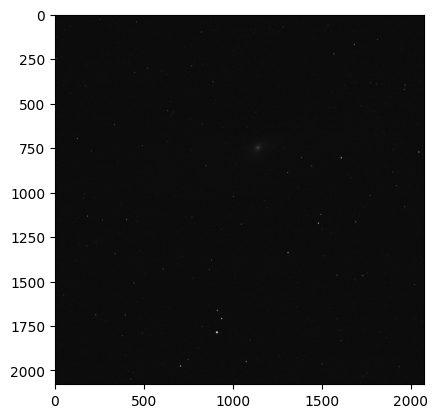

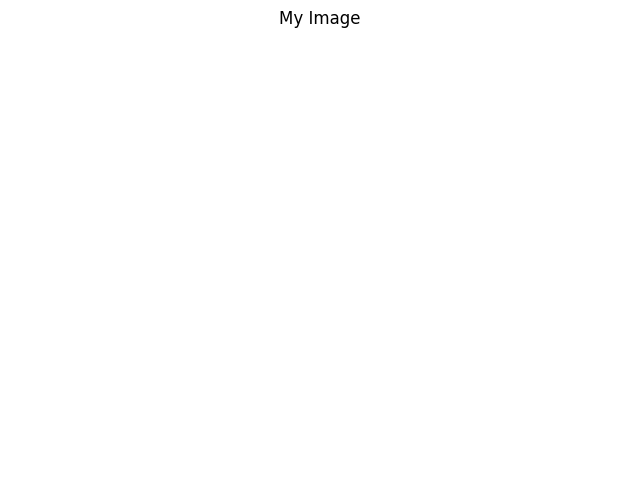

In [ ]:
img = mpimg.imread(cal_png) 

plt.figure(figsize=(8, 6))
plt.imshow(img)
# Display the image

plt.title("My Image")

plt.axis('off')

plt.show()

In [18]:
calibrated_files = sorted(calibrated_dir.glob("calibrated_*.fit"))

if not calibrated_files:
    print("No calibrated FITS files found in:", calibrated_dir)
else:
    calibrated_fits = calibrated_files[len(calibrated_files) // 2]
    print("Using calibrated FITS:", calibrated_fits.name)

    stacked_fits = stack_output / "stacked.fits"
    if not stacked_fits.exists():
        print("Stacked FITS not found:", stacked_fits)
    else:
        print("Using stacked FITS:", stacked_fits.name)

        cal_png = preview_dir / "calibrated_for_stack_preview.png"
        stacked_png = preview_dir / "stacked_preview.png"

        # Load data
        cal_data = fits.getdata(calibrated_fits)
        stacked_data = fits.getdata(stacked_fits)

        # Shared stretch using your existing helper
        cal_disp, stacked_disp = stretch_pair_for_preview(cal_data, stacked_data)

        # Save PNGs
        plt.imsave(cal_png, cal_disp, cmap="gray")
        plt.imsave(stacked_png, stacked_disp, cmap="gray")

        # Show popup
        show_step_preview(cal_png, stacked_png,
                          window_title="Calibrated vs Aligned & Stacked")

Using calibrated FITS: calibrated__MG_4380.fit
Using stacked FITS: stacked.fits


---
# Color Post-Processing

This section takes the final **stacked FITS file** and applies non-linear stretching, color balancing, and contrast adjustments to produce the final aesthetically pleasing image.

### Steps done
1. Demoslicing
2. Dynamic Background Subtraction
3. Detail Enhancements
4. Non-Linear Streaching
5. Color and Contrast Boosting

--- 
## 1. Demosaicing (Color Reconstruction)
* **Process:** The raw stacked data is a **monochrome** FITS file with a Bayer pattern (e.g., RGGB). This step separates the pixels into three distinct R, G, and B arrays and stacks them into a 3D color image array.
* **Method:**
    * R: Every pixel at position `[::2, ::2]`
    * B: Every pixel at position `[1::2, 1::2]`
    * G: The average of the remaining green pixels.

## 2. Dynamic Background Subtraction 

* **Function:** `remove_gradient()`
* **Purpose:** Removes subtle, wide-field illumination **gradients** that still exist.
* **Process:**
    1.  The image is divided into a grid (e.g., $64 \times 64$ mesh).
    2.  The **median** (background level) is calculated for each tile.
    3.  A smooth background model (`bg_model`) is created from these medians using a **Gaussian filter**.
    4.  The model is subtracted from the original image: $\text{Image}_{\text{detrended}} = \text{Image} - \text{bg\_model}$. This is performed **per color channel** to ensure accurate background removal.

## 3. Detail Enhancement

* **Denoising:** Bilateral and median filters are applied to smooth noise without losing important structure.
* **Star Reduction:** The `star_reduction()` function is used to selectively reduce the brightness or size of stars to make the **galaxy or nebula detail more prominent** (`img_galaxy_dominant`).
    * This is done by finding the difference between the original image and a heavily blurred version (`galaxy_model`).

## 4. Non-Linear Stretching (The "Galaxy Pop")

* **Function:** `stretched = np.arcsinh(img_clean * STRETCH_MULTIPLIER)`
* **Purpose:** Raw astronomical data is highly **linear**—faint structures are invisible. The **arcsinh** aggressively brightens faint signals while compressing bright signals, making the detail visible to the human eye. 
* **Local Contrast:** Detail is further enhanced by unsharp masking—separating low-frequency blur from high-frequency detail and boosting the high-frequency components (`high_freq_detail * BOOST_FACTOR`).

## 5. Color and Contrast Finalization

1.  **Color Balancing:** A white balance is performed by measuring the **median Green channel** and adjusting the Red and Blue channels to match this neutral gray point. Custom factors (`RED_PUSH`, `BLUE_PUSH`) can be applied for artistic control.
2.  **Saturation Boost:** The color saturation is increased to make the image vibrant.
3.  **Black Point Adjustment:** Shadows are "crushed" by subtracting a `BLACK_POINT` value. This ensures the background sky is truly black, not a lifted gray.
4.  **Gamma Adjustment:** A **Gamma** correction is applied ($\text{Image} = \text{Image}^{\gamma}$) to brighten mid-tones, giving the final image pop and defining the internal structure of the nebula or galaxy.


In [21]:
base_dir = Path("./data")
fits_dir = base_dir / "fits_data/"
stack_output = fits_dir / "stacked"

input_stack_file = stack_output / "stacked.fits"
output_fits = fits_dir / "processed" / "processed_color.fit"
output_png = fits_dir / "processed" / "processed_color.png"
output_fits.parent.mkdir(parents=True, exist_ok=True)


GRADIENT_MESH_SIZE = 64
STRETCH_MULTIPLIER = 0.080   # Aggressive stretch to lift faint detail.
STAR_REDUCTION_FACTOR = 0.4  # Keeps stars brighter (less reduction).
SATURATION_BOOST = 2.0       # Vibrant color.
BLUE_PUSH = 1.00
RED_PUSH = 1.00
BOOST_FACTOR = 0.8           # Local contrast applied to the STRETCHED image.
BLACK_POINT = 1.8            # Crushes the lifted gray background to black.
GAMMA = 0.8                  # Brightens mid-tones (galaxy structure) for final pop.


def remove_gradient(img, mesh=GRADIENT_MESH_SIZE):
    """Dynamically estimate and subtract the background gradient (DBE)."""
    h, w = img.shape
    bg_model = np.zeros_like(img, dtype=np.float32)
    for y in range(0, h, mesh):
        for x in range(0, w, mesh):
            tile = img[y:y+mesh, x:x+mesh]
            bg = np.median(tile)
            bg_model[y:y+mesh, x:x+mesh] = bg
    bg_model = gaussian_filter(bg_model, sigma=mesh/2)
    return img - bg_model


def star_reduction(img, sigma=15, reduction_factor=STAR_REDUCTION_FACTOR):
    """Controls star size. Lower reduction_factor means brighter stars."""
    galaxy_model = gaussian_filter(img, sigma=sigma)
    star_mask = img - galaxy_model
    return img - (star_mask * reduction_factor)


def run_post_processing():
    print("\n--- Starting Final Color Post-Processing ---")


    print("1. Loading and Demosaicing stacked data.")
    if not input_stack_file.exists():
        print(f"Error: Stacked file not found at {input_stack_file}")
        return

    stacked_ccd = ccdp.CCDData.read(str(input_stack_file), unit=u.adu) # type: ignore
    data = stacked_ccd.data.astype(np.float32)

    # Assumes RGGB pattern for array slicing
    try:
        R = data[::2, ::2]
        G = (data[::2, 1::2] + data[1::2, ::2]) / 2.0
        B = data[1::2, 1::2]
        color_image = np.dstack([R, G, B])
        if color_image.ndim != 3 or color_image.shape[2] != 3:
             raise ValueError("NumPy separation failed.")

    except Exception as e:
        print(f"\nCRITICAL ERROR: Demosaicing failed: {e}")
        sys.exit(1)


    print("2. Removing gradients from each color channel.")
    img_detrended_r = remove_gradient(color_image[:, :, 0])
    img_detrended_g = remove_gradient(color_image[:, :, 1])
    img_detrended_b = remove_gradient(color_image[:, :, 2])
    img_detrended_color = np.dstack([img_detrended_r, img_detrended_g, img_detrended_b])



    print("3. Applying noise reduction and star reduction.")
    img_denoised = denoise_bilateral(
        img_detrended_color, sigma_color=0.05, sigma_spatial=2, channel_axis=2
    )
    img_denoised = median_filter(img_denoised, size=3)

    img_galaxy_dominant = np.zeros_like(img_denoised)
    for i in range(3):
        img_galaxy_dominant[:, :, i] = star_reduction(img_denoised[:, :, i])

    # Clean up negatives before stretching
    img_clean = img_galaxy_dominant - np.min(img_galaxy_dominant)


    print("4. Applying aggressive non-linear stretch (Galaxy POP).")
    stretched = np.arcsinh(img_clean * STRETCH_MULTIPLIER)
    img_contrast_base = stretched


    print("5. Applying local contrast enhancement.")
    # Now that the image is stretched, we can safely use a higher BOOST_FACTOR
    blurred_low_freq = gaussian_filter(img_contrast_base, sigma=30, axes=2)
    high_freq_detail = img_contrast_base - blurred_low_freq

    img_final_base = img_contrast_base + (high_freq_detail * BOOST_FACTOR)
    img_balanced = img_final_base.copy()


    print("6. Color balancing.")
    # Color balance applied to the stretched data
    median_g = np.median(img_balanced[:, :, 1])
    r_factor = median_g / np.median(img_balanced[:, :, 0])
    b_factor = median_g / np.median(img_balanced[:, :, 2])

    img_balanced[:, :, 0] *= r_factor * RED_PUSH
    img_balanced[:, :, 2] *= b_factor * BLUE_PUSH


    print("7. Boosting color saturation.")
    color_boosted = img_balanced.copy()
    luminance = np.mean(color_boosted, axis=2, keepdims=True)
    color_boosted = luminance + (color_boosted - luminance) * SATURATION_BOOST
    color_boosted = np.clip(color_boosted, 0, None)


    print("8. Adjusting contrast to crush blacks.")

    # Clip shadows to absolute zero (DARK BACKGROUND)
    contrast_adjusted = color_boosted - BLACK_POINT
    contrast_adjusted[contrast_adjusted < 0] = 0

    # Rescale to 0-1 and apply Gamma (POP the galaxy)
    max_val = np.max(contrast_adjusted)
    if max_val > 0:
        contrast_adjusted /= max_val
    contrast_adjusted = np.power(contrast_adjusted, GAMMA)
    color_boosted = contrast_adjusted


    # 9. Save Results
    print("9. Saving results.")
    stretched_norm = rescale_intensity(color_boosted, out_range=(0,1)) # type: ignore

    hdu = fits.PrimaryHDU(color_boosted.astype(np.float32))
    hdu.writeto(str(output_fits), overwrite=True)

    plt.imsave(str(output_png), stretched_norm)

    print("\nColor Post-Processing complete!")

run_post_processing()


--- Starting Final Color Post-Processing ---
1. Loading and Demosaicing stacked data.
2. Removing gradients from each color channel.
3. Applying noise reduction and star reduction.
4. Applying aggressive non-linear stretch (Galaxy POP).
5. Applying local contrast enhancement.
6. Color balancing.
7. Boosting color saturation.
8. Adjusting contrast to crush blacks.
9. Saving results.

Color Post-Processing complete!


In [22]:
stacked_fits = stack_output / "stacked.fits"
final_png = fits_dir / "processed" / "processed_color.png"

if stacked_fits.exists() and final_png.exists():
    stacked_png = preview_dir / "stacked_preview.png"

    stacked_data = fits.getdata(stacked_fits)
    stacked_disp, _ = stretch_pair_for_preview(stacked_data, stacked_data)  # just reuse stretch
    plt.imsave(stacked_png, stacked_disp, cmap="gray")

    show_step_preview(stacked_png, final_png, window_title="Stacked vs Post Processed")